In [142]:
import numpy as np
from numpy import array, average, arange, linspace, sin, cos, sqrt, zeros, ones, eye, vstack, hstack, ones_like, zeros_like
from numpy.random import normal, multivariate_normal
from numpy.linalg import inv, norm
import matplotlib.pyplot as plt

### Truth Signal and GPS/Accel Signal

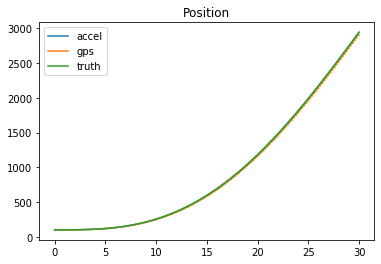

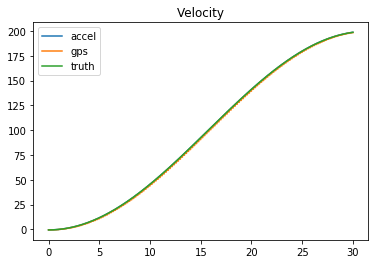

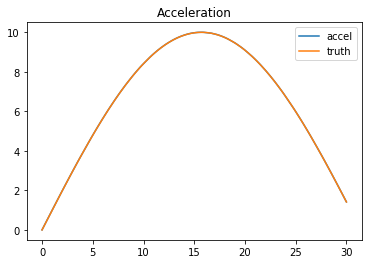

In [162]:
# sampling rate
fs_accel = 200 # Hz
fs_gps = 5
fs_kal = int(1 / 0.02) # 50

# Number of samples - select N s.t. this system runs for 30s
N_accel = 200 * 30 # 200 Hz * 30s = 6000
N_gps = int(N_accel * fs_gps / fs_accel) # 150
N_kal = int(N_accel * fs_kal / fs_accel) # 1500
t_accel = arange(N_accel) / fs_accel
t_gps = t_accel[::40]
t_kal = t_accel[::4]


##### Dynamical System #####
delta_t = 1 / fs_accel # speyer uses 0.02s for some reason
Phi = array([[1, delta_t, delta_t**2/2],
             [0, 1,       delta_t     ],
             [0, 0,       1            ]])
Gamma = array([delta_t**2/2, delta_t, 0])


##### State Truth Signal #####
omega = 0.1 # rad/s
a = 10
v_0_bar = 0
p_0_bar = 100
v_0 = normal(v_0_bar, 10)
p_0 = normal(p_0_bar, 1)
a_t = a * np.sin(omega*t_accel)
v_t = v_0 + a / omega - a / omega * cos(omega * t_accel)
p_t = p_0 + (v_0 + a / omega) * t_accel - a / omega**2 * sin(omega * t_accel)
x_truth = np.vstack([p_t, v_t, a_t]).T


##### Accelerometer Signal #####
x_accel = np.zeros((N_accel, 3))
x_E = np.zeros((N_accel, 3))
x_E[:,2] = x_truth[:,2]
x_E[0,:2] = array([p_0, v_0])
w_t = normal(0,0.0004, N_accel)
b_a = normal(0,0.01)
x_accel[:,2] = a_t + b_a + w_t
x_accel[0,0:2] = array([p_0, v_0])
for i in range(1, N_accel):
    x_accel[i,:2] = (Phi @ x_accel[i-1])[:2]
    x_E[i,:2] = (Phi @ x_E[i-1])[:2]
x_c = x_accel
    

##### GPS #####
x_gps = np.zeros((N_gps, 3)) # includes a row for accel but its 0
gps_noise_avg = array([0,0])
gps_noise_cov = array([[1, 0      ],
                       [0, 0.04**2]])
V = gps_noise_cov
v = multivariate_normal(gps_noise_avg, gps_noise_cov, N_gps) 
eta = v
x_gps[:,0:2] = x_truth[::40,0:2] + v
z = zeros((N_accel, 2))
for k in range(N_accel):
    z[k] = x_gps[k // 40, 0:2]

# %matplotlib qt
%matplotlib inline
plt.plot(t_accel, x_accel[:,0], label='accel')
plt.plot(t_accel, z[:,0], label='gps')
plt.plot(t_accel, x_truth[:,0], label='truth')
plt.legend()
plt.title("Position")
plt.show()
plt.plot(t_accel, x_accel[:,1], label='accel')
plt.plot(t_accel, z[:,1], label='gps')
plt.plot(t_accel, x_truth[:,1], label='truth')
plt.legend()
plt.title("Velocity")
plt.show()
plt.plot(t_accel, x_accel[:,2], label='accel')
plt.plot(t_accel, x_truth[:,2], label='truth')
plt.legend()
plt.title("Acceleration")
plt.show()

### Kalman Filter

In [163]:
##### State Matrices/Arrays #####
x_bar = zeros((N_accel, 3)) # a posteriori/max f(x|z)
M = np.zeros((N_accel, 3, 3)) # a posteriori cov, generated after measurement
x_hat = zeros((N_accel, 3)) # a priori/dynamically propogated
P = np.zeros((N_accel, 3, 3)) # a priori cov, generated b/w measurements
K = zeros((N_accel, 3, 2)) # Kalman gain
W = array([[1, 0,    0], # Additive noise average is just 0, W_avg = array([0,0,0])
           [0, 0.04, 0],
           [0, 0,    0]])
H = array([[1, 0, 0],
           [0, 1, 0]])
I = eye(3)


##### Initiliztion #####
x_bar[0] = array([p_0, v_0, b_a])
M[0] = array([[10,0, 0   ],
              [0, 1, 0   ],
              [0, 0, 0.01]])
K[0] = M[0] @ H.T @ inv(H @ M[0] @ H.T + V)
P[0] = M[0]
x_hat[0] = x_bar[0] + P[0] @ H.T @ inv(V) @ (z[0] - H @ x_bar[0])


##### Acceleration Invariant Stuff #####
# delta_t = 0.02
delta_t = 1 / fs_accel
Phi_kalman = array([[1, delta_t, -delta_t**2/2],
                    [0, 1,       -delta_t     ],
                    [0, 0,       1            ]])
delta_x_bar = zeros((N_accel, 3))
delta_x = zeros((N_accel, 3))
M_kalman = np.zeros((N_accel, 3, 3)) # a posteriori cov, generated after measurement
P_kalman = np.zeros((N_accel, 3, 3))
K_kalman = zeros((N_accel, 3, 2)) # Kalman gain
delta_x_E = zeros((N_accel, 3))
delta_x_bar = zeros((N_accel, 3))
delta_z = x_accel[:,:2] - z
delta_z = z - x_accel[:,:2]
# V_kalman = M[0,:2,:2] + V
V_kalman = V
# V_kalman = 
delta_x_hat = zeros((N_accel, 3))
delta_x = x_truth - x_accel # 3rd term just b_a?
delta_x[:,2] = -delta_x[:,2]
# delta_x = x_accel - x_truth


# P_kalman[0] = P[0]
P_kalman[0] = (I - K_kalman[0] @ H) @ M_kalman[0] @ (I - K_kalman[0] @ H).T + K_kalman[k] @ V_kalman @ K_kalman[k].T
delta_x_E[0,:2] = x_E[0,:2] - x_c[0,:2]
delta_x_E[0,:2] = b_a
delta_x_bar[0,:2] = x_bar[0,:2] - x_c[0,:2] # x_bar[0]: p_0, v_0, b_a; x_c[0]: p_0, v_0, b_a + w_t
delta_x_bar[0,2] = 0
M_kalman[0] = M[0]
K_kalman[0] = M_kalman[0] @ H.T @ inv(H @ M_kalman[0] @ H.T + V_kalman) 
A = I - K_kalman[0] @ H
P_kalman[0] =  A @ M_kalman[0] @ A.T + K_kalman[0] @ V_kalman @ K_kalman[0].T
delta_x_hat[0] = delta_x_bar[0] + P_kalman[0] @ H.T @ inv(V_kalman) @ (delta_z[0] - H @ delta_x_bar[0]) # idk about this
print(delta_x_bar[0], delta_x_hat[0], delta_z[0])
print(delta_z[0] - H @ delta_x_bar[0])


##### Kalman Filter #####
M_k_term_2 = Gamma @ W @ Gamma.T
error = zeros((N_accel, 3))
for k in range(1, N_accel):
    if (k>0):
    ##### Standard Kalman Filter, Depends on acceleration #####
        # Before measurement
        x_bar[k] = Phi @ x_hat[k-1]
        M[k] = Phi @ P[k-1] @ Phi.T + M_k_term_2
        K[k] = M[k] @ H.T @ inv(H @ M[k] @ H.T + V)
        # After measurement
        A = I - K[k] @ H # temp variable for effeciency
        P[k] =  A @ M[k] @ A.T + K[k] @ V @ K[k].T
        x_hat[k] = x_bar[k] + P[k] @ H.T @ inv(V) @ (z[k] - H @ x_bar[k])
    
    ##### Acceleration Invariant Stuff #####
    # Prediction before measurement
    delta_x_E[k] = Phi_kalman @ delta_x_E[k-1] - Gamma * w_t[k-1]
    delta_x_bar[k] = Phi_kalman @ delta_x_hat[k-1]
    M_kalman[k] = Phi_kalman @ P_kalman[k-1] @ Phi_kalman.T + M_k_term_2
    # Measurement: z[k]
    K_kalman[k] = M_kalman[k] @ H.T @ inv(H @ M_kalman[k] @ H.T + V_kalman) # TODO: if I dont need to store make temp
    A = I - K_kalman[k] @ H # temp variable for effeciency
    if not (k%40):
        P_kalman[k] =  A @ M_kalman[k] @ A.T + K_kalman[k] @ V_kalman @ K_kalman[k].T
        delta_x_hat[k] = delta_x_bar[k] + P_kalman[k] @ H.T @ inv(V_kalman) @ (delta_z[k] - H @ delta_x_bar[k])
    else:
        P_kalman[k] = M_kalman[k]
        delta_x_hat[k] = delta_x_bar[k]

error_bar_1 = delta_x - delta_x_bar

[0. 0. 0.] [0.82507248 0.06767653 0.        ] [0.90757972 0.06778481]
[0.90757972 0.06778481]


b_a: 0.0031274264364546406 0.0 0.0


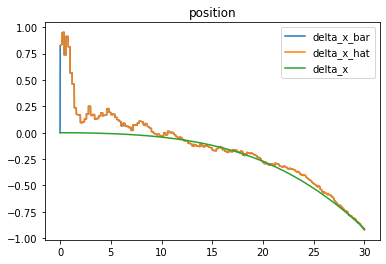

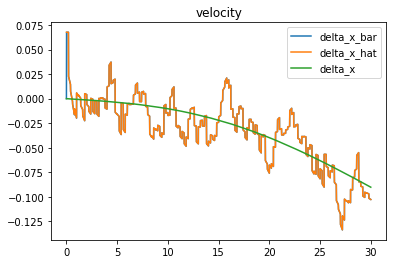

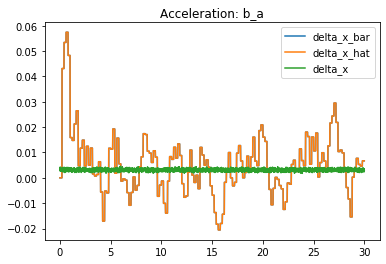

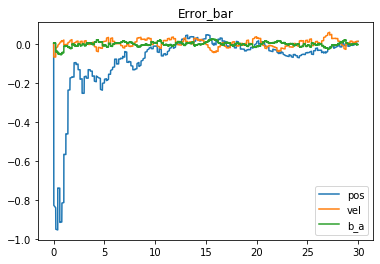

In [164]:
# %matplotlib qt
%matplotlib inline
print("b_a:", b_a, delta_x_bar[0,2], delta_x_hat[0,2])
plt.figure()
plt.plot(t_accel, delta_x_bar[:,0], label='delta_x_bar')
plt.plot(t_accel[1:], delta_x_hat[1:,0], label='delta_x_hat')
plt.plot(t_accel, delta_x[:,0], label='delta_x')
plt.title("position")
plt.legend()

plt.figure()
plt.plot(t_accel, delta_x_bar[:,1], label='delta_x_bar')
plt.plot(t_accel[1:], delta_x_hat[1:,1], label='delta_x_hat')
plt.plot(t_accel, delta_x[:,1], label='delta_x')
plt.title("velocity")
plt.legend()

plt.figure()
plt.plot(t_accel, delta_x_bar[:,2], label='delta_x_bar')
plt.plot(t_accel, delta_x_hat[:,2], label='delta_x_hat')
plt.plot(t_accel, delta_x[:,2], label='delta_x')
plt.title("Acceleration: b_a")
plt.legend()
plt.show()

plt.figure()
plt.plot(t_accel, error_bar_1)
# plt.plot(t_accel, error_bar[:,2], label='delta_x_bar')
# plt.plot(t_accel, error_bar[:,2], label='delta_x_hat')
# plt.plot(t_accel, error_bar[:,2], label='delta_x')
plt.title("Error_bar")
plt.legend(("pos", "vel", "b_a"))
plt.show()

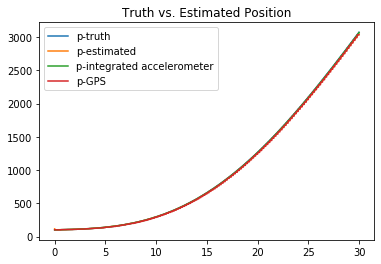

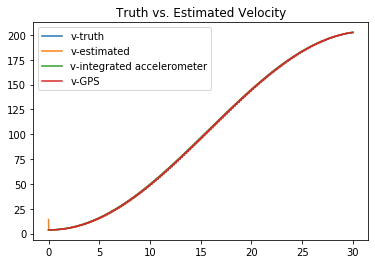

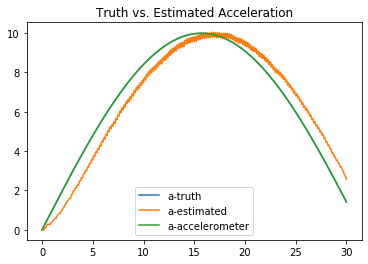

In [148]:
##### Plots #####
plt.figure()
plt.plot(t_accel, x_truth[:,0], label="p-truth")
plt.plot(t_accel, x_hat[:,0], label="p-estimated")
plt.plot(t_accel, x_accel[:,0], label="p-integrated accelerometer")
plt.plot(t_accel, z[:,0], label="p-GPS")
plt.title("Truth vs. Estimated Position")
plt.legend()
# plt.show()
plt.figure()
plt.plot(t_accel, x_truth[:,1], label="v-truth")
plt.plot(t_accel, x_hat[:,1], label="v-estimated")
plt.plot(t_accel, x_accel[:,1], label="v-integrated accelerometer")
plt.plot(t_accel, z[:,1], label="v-GPS")
plt.title("Truth vs. Estimated Velocity")
plt.legend()
# plt.show()
plt.figure()
plt.plot(t_accel, x_truth[:,2], label="a-truth")
plt.plot(t_accel, x_hat[:,2], label="a-estimated")
plt.plot(t_accel, x_accel[:,2], label="a-accelerometer")
# plt.plot(t_accel, z[:,0], label="p-GPS")
plt.title("Truth vs. Estimated Acceleration")
plt.legend()
plt.show()
# plt.title("Norm of Error Vector without Acceleration Component")
# plt.plot(t_accel, norm(error[:,:2], axis=1))
# plt.show()
# # Taking out the normalization with x_truth eliminates the weird value
# plt.title("% Position Error")
# plt.plot(t_accel, error[:,0] / x_truth[:,0])
# plt.show()
# plt.title("% Velocity Error")
# plt.plot(t_accel, error[:,1] / x_truth[:,1])
# plt.show()
# plt.title("% Acceleration Error")
# plt.plot(t_accel, error[:,2] / x_truth[:,2])
# plt.show()

## Effecient Version for MC

In [125]:
N_trials = 1000
# sampling rate
fs_accel = 200 # Hz
fs_gps = 5
fs_kal = int(1 / 0.02) # 50

# Number of samples - select N s.t. this system runs for 30s
N_accel = 200 * 30 # 200 Hz * 30s = 6000
N_gps = int(N_accel * fs_gps / fs_accel) # 150
N_kal = int(N_accel * fs_kal / fs_accel) # 1500
t_accel = arange(N_accel) / fs_accel
t_gps = t_accel[::40]
t_kal = t_accel[::4]

##### MC Variables #####
error_bar = zeros((N_trials, N_accel, 3))
residuals = zeros((N_trials, N_accel, 2))


##### Dynamical System #####
delta_t = 1 / fs_accel # speyer uses 0.02s for some reason
Phi = array([[1, delta_t, delta_t**2/2],
             [0, 1,       delta_t     ],
             [0, 0,       1            ]])
Gamma = array([delta_t**2/2, delta_t, 0])


##### State Truth Signal #####
omega = 0.1 # rad/s
a = 10
v_0_bar = 0
p_0_bar = 100
v_0 = normal(v_0_bar, 10)
p_0 = normal(p_0_bar, 1)
a_t = a * np.sin(omega*t_accel)
v_t = v_0 + a / omega - a / omega * cos(omega * t_accel)
p_t = p_0 + (v_0 + a / omega) * t_accel - a / omega**2 * sin(omega * t_accel)
x_truth = np.vstack([p_t, v_t, a_t]).T


##### Monte-Carlo #####
for trial in range(N_trials):
    ##### Accelerometer Signal #####
    x_accel = np.zeros((N_accel, 3))
    x_E = np.zeros((N_accel, 3))
#     x_E[:,2] = x_truth[:,2]
#     x_E[0,:2] = array([p_0, v_0])
    w_t = normal(0,0.0004, N_accel)
    b_a = normal(0,0.01)
    x_accel[:,2] = a_t + b_a + w_t
    x_accel[0,0:2] = array([p_0, v_0])
    for i in range(1, N_accel):
        x_accel[i,:2] = (Phi @ x_accel[i-1])[:2]
#         x_E[i,:2] = (Phi @ x_E[i-1])[:2]
    x_c = x_accel


    ##### GPS #####
    x_gps = np.zeros((N_gps, 3)) # includes a row for accel but its 0
    gps_noise_avg = array([0,0])
    gps_noise_cov = array([[1, 0      ],
                           [0, 0.04**2]])
    V = gps_noise_cov
    v = multivariate_normal(gps_noise_avg, gps_noise_cov, N_gps) 
    eta = v
    x_gps[:,0:2] = x_truth[::40,0:2] + v
    z = zeros((N_accel, 2))
    for k in range(N_accel):
        z[k] = x_gps[k // 40, 0:2]


    ##### State Matrices/Arrays #####
    x_bar = zeros((N_accel, 3)) # a posteriori/max f(x|z)
    M = np.zeros((N_accel, 3, 3)) # a posteriori cov, generated after measurement
    x_hat = zeros((N_accel, 3)) # a priori/dynamically propogated
    P = np.zeros((N_accel, 3, 3)) # a priori cov, generated b/w measurements
    K = zeros((N_accel, 3, 2)) # Kalman gain
    W = array([[1, 0,    0], # Additive noise average is just 0, W_avg = array([0,0,0])
               [0, 0.04, 0],
               [0, 0,    0]])
    H = array([[1, 0, 0],
               [0, 1, 0]])
    I = eye(3)


    ##### Initiliztion #####
    x_bar[0] = array([p_0, v_0, b_a])
    M[0] = array([[10,0, 0   ],
                  [0, 1, 0   ],
                  [0, 0, 0.01]])
    K[0] = M[0] @ H.T @ inv(H @ M[0] @ H.T + V)
    P[0] = M[0]
    x_hat[0] = x_bar[0] + P[0] @ H.T @ inv(V) @ (z[0] - H @ x_bar[0])


    ##### Acceleration Invariant Stuff #####
    # delta_t = 0.02
    delta_t = 1 / fs_accel
    Phi_kalman = array([[1, delta_t, -delta_t**2/2],
                        [0, 1,       -delta_t     ],
                        [0, 0,       1            ]])
    delta_x_bar = zeros((N_accel, 3))
    delta_x = zeros((N_accel, 3))
    M_kalman = np.zeros((N_accel, 3, 3)) # a posteriori cov, generated after measurement
    P_kalman = np.zeros((N_accel, 3, 3))
    K_kalman = zeros((N_accel, 3, 2)) # Kalman gain
#     delta_x_E = zeros((N_accel, 3))
    delta_x_bar = zeros((N_accel, 3))
    delta_z = x_accel[:,:2] - z
    delta_z = z - x_accel[:,:2]
    # V_kalman = M[0,:2,:2] + V
    V_kalman = V
    # V_kalman = 
    delta_x_hat = zeros((N_accel, 3))
    delta_x = x_truth - x_accel # 3rd term just b_a?
    delta_x[:,2] = -delta_x[:,2]
    # delta_x = x_accel - x_truth


    # P_kalman[0] = P[0]
    P_kalman[0] = (I - K_kalman[0] @ H) @ M_kalman[0] @ (I - K_kalman[0] @ H).T + K_kalman[k] @ V_kalman @ K_kalman[k].T
#     delta_x_E[0,:2] = x_E[0,:2] - x_c[0,:2]
#     delta_x_E[0,:2] = b_a
    delta_x_bar[0,:2] = x_bar[0,:2] - x_c[0,:2] # x_bar[0]: p_0, v_0, b_a; x_c[0]: p_0, v_0, b_a + w_t
    delta_x_bar[0,2] = 0
    M_kalman[0] = M[0]
    K_kalman[0] = M_kalman[0] @ H.T @ inv(H @ M_kalman[0] @ H.T + V_kalman) 
    A = I - K_kalman[0] @ H
    P_kalman[0] =  A @ M_kalman[0] @ A.T + K_kalman[0] @ V_kalman @ K_kalman[0].T
    delta_x_hat[0] = delta_x_bar[0] + P_kalman[0] @ H.T @ inv(V_kalman) @ (delta_z[0] - H @ delta_x_bar[0]) # idk about this

    residuals[trial, 0] = delta_z[0] - H @ delta_x_bar[0]
    
    ##### Kalman Filter #####
    M_k_term_2 = Gamma @ W @ Gamma.T
    error = zeros((N_accel, 3))
    for k in range(1, N_accel):
        ##### Acceleration Invariant Stuff #####
        # Prediction before measurement
#         delta_x_E[k] = Phi_kalman @ delta_x_E[k-1] - Gamma * w_t[k-1]
        delta_x_bar[k] = Phi_kalman @ delta_x_hat[k-1]
        M_kalman[k] = Phi_kalman @ P_kalman[k-1] @ Phi_kalman.T + M_k_term_2
        # Measurement: z[k]
        K_kalman[k] = M_kalman[k] @ H.T @ inv(H @ M_kalman[k] @ H.T + V_kalman) # TODO: if I dont need to store make temp
        A = I - K_kalman[k] @ H # temp variable for effeciency
        if not (k%40):
            P_kalman[k] =  A @ M_kalman[k] @ A.T + K_kalman[k] @ V_kalman @ K_kalman[k].T
            delta_x_hat[k] = delta_x_bar[k] + P_kalman[k] @ H.T @ inv(V_kalman) @ (delta_z[k] - H @ delta_x_bar[k])
        else:
            P_kalman[k] = M_kalman[k]
            delta_x_hat[k] = delta_x_bar[k]
        residuals[trial, k] = delta_z[k] - H @ delta_x_bar[k]

    error_bar[trial] = delta_x - delta_x_bar
    print("\rProgress: [{0:50s}] {1:.1f}%".format('#' * int(trial/N_trials * 50), trial/N_trials*100), end="", flush=True)

print("\ndone")

Progress: [################################################# ] 99.9%
done


(1000, 6000, 3) (6000, 3)


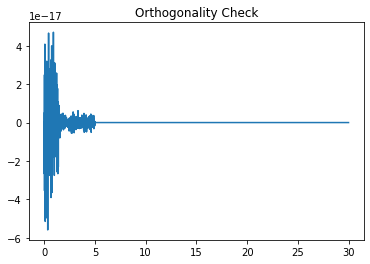

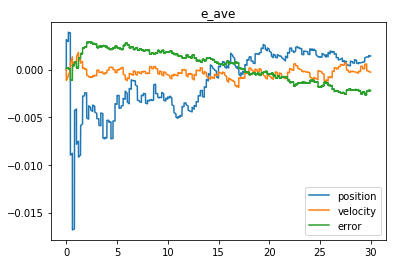

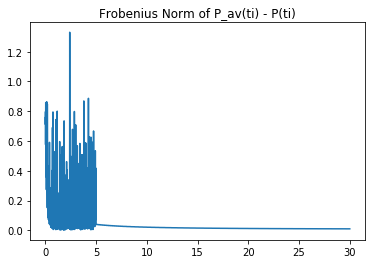

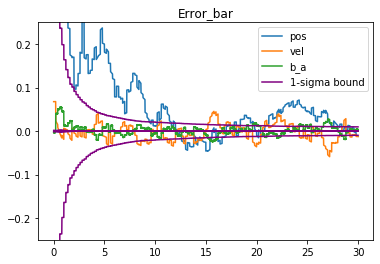

-0.033807051025035756


In [171]:
# %matplotlib qt
%matplotlib inline
error_bar_avg = average(error_bar, axis=0)
error_bar_variance = np.var(error_bar, axis=0)
print(error_bar.shape, error_bar_avg.shape)
ortho_check = zeros(N_accel)
P_av = zeros((N_accel, 3, 3))
for i in range(N_trials):
    P_av[i] += (error_bar[i] - error_bar_avg).T @ (error_bar[i] - error_bar_avg)
    ortho_check[i] = average((error_bar[:,i] - error_bar_avg[i]) @ delta_x_hat[i].T, axis=0)
plt.figure()
plt.title("Orthogonality Check")
plt.plot(t_accel, ortho_check) # good, all near 0
    
P_av /= (N_trials -1)

plt.figure()
plt.plot(t_accel, error_bar_avg)
plt.legend(("position", "velocity", "error"))
plt.title("e_ave")

# P_av shoul dbe close to P_kalman
plt.figure()
plt.title("Frobenius Norm of P_av(ti) - P(ti)")
plt.plot(t_accel, norm(P_av - P_kalman, ord='fro', axis=(1,2)))
# 1000 x 6000 x 3

ortho = average(error_bar - error_bar_avg, axis=0) @ x_hat.T

plt.figure()
# plt.plot(t_accel, error_bar_avg)
plt.plot(t_accel, delta_x_hat - delta_x)
plt.plot(t_accel[1:], error_bar_variance[1:], color='purple')
plt.plot(t_accel[1:], -error_bar_variance[1:], color='purple')
plt.ylim(-0.25,0.25)
plt.title("Error_bar")
plt.legend(("pos", "vel", "b_a", "1-sigma bound"))
plt.show()


##### Residuals #####
# residuals: N_trials, 6000, 2
# N_trials x 2 @ 2 x N_trials
residuals[:,100] @ residuals[:,10].T
residual_avg = 1 / N_trials * np.trace(residuals[:,200] @ residuals[:,10].T)
print(residual_avg)

-0.033807051025035756


## Difference of Integration of Accelerometer and GPS
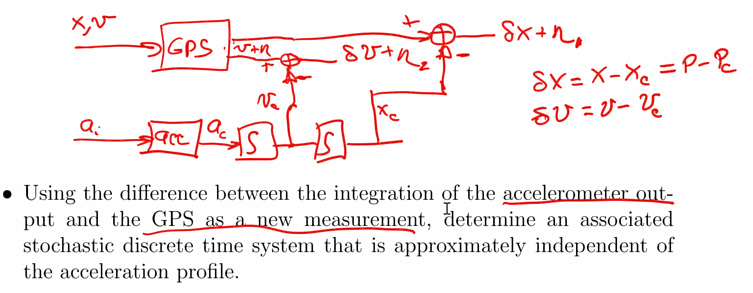

## Implement Kalman Filter for the Stochastic System
Show estimates of bias in: (me: just take expected values)
-Position Bias

-Velocity Bias

-Accelerometer Bias

-Filter error variance for one realization

Include the one-sigma bound, one-sigma bound will always be variance
P_k matrix cross-terms will have 
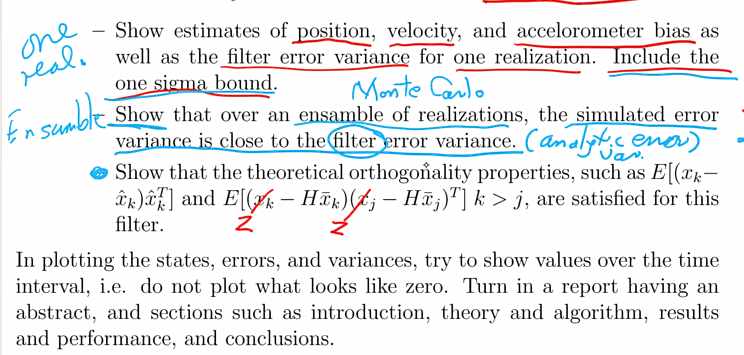

To show orthogonality, need ensembles ie run after run after run to show the expected value of something is equal to 0
Average the expectation run after run to plot expectation of the sum of l from 1 to m (e_m^P x_k^T) is equal to zero after a lot of runs

## Calibration of Accelerometer Using GPS

In [6]:
# Obtained form a_tj = a * sin(omega*t) by integration


## Accelerometer Model

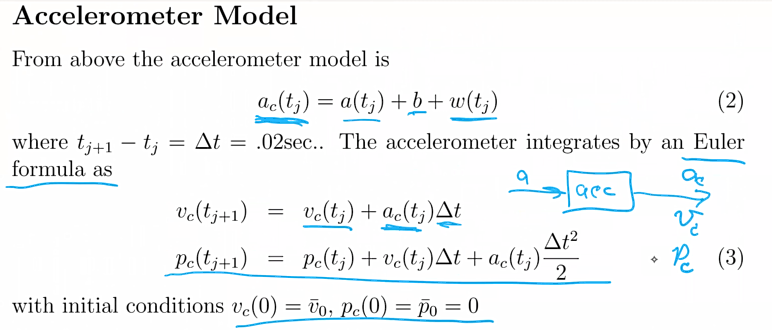

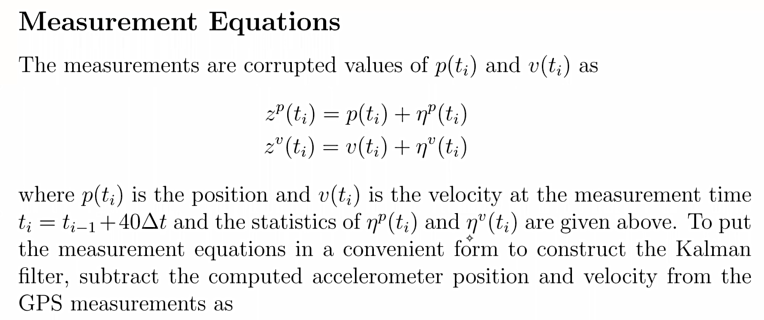

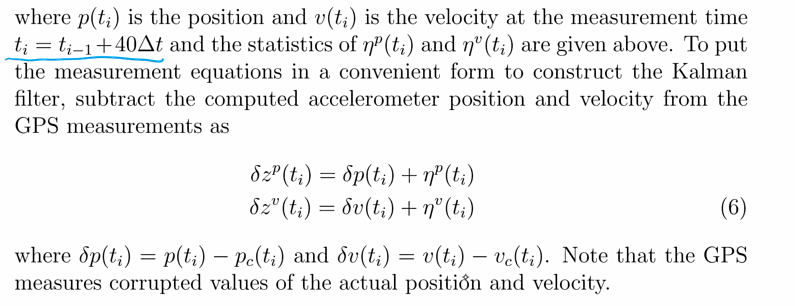

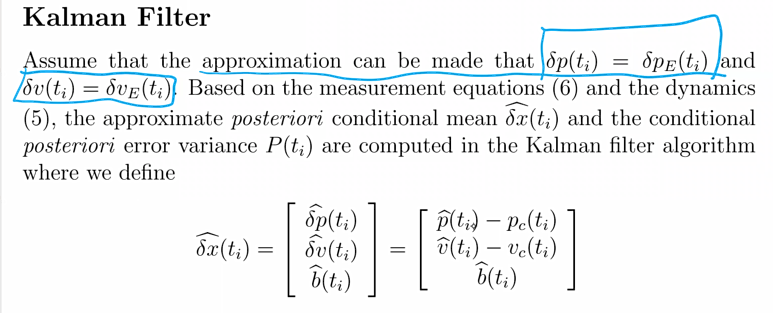

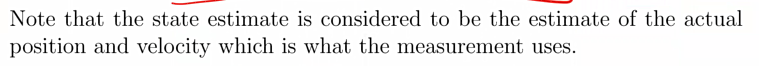

## Monte Carlo Simulation
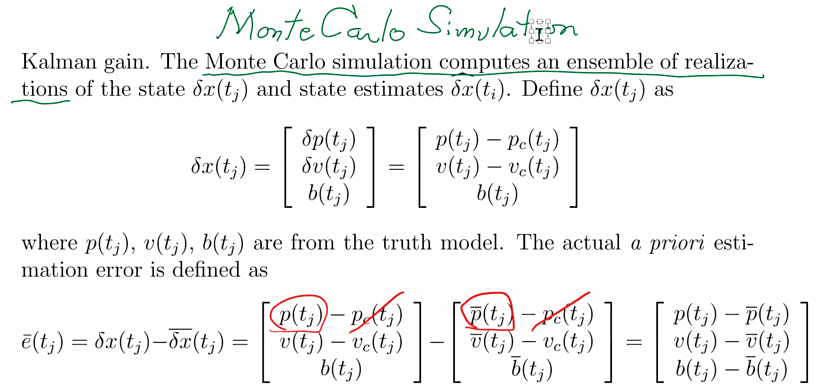
Used to ensure the Kalman filter is computer correctly

Difference of deltas is delta_x_tj: state and delta_x_tj_bar: a-priori estimate of state. This gives the a-priori error e_bar

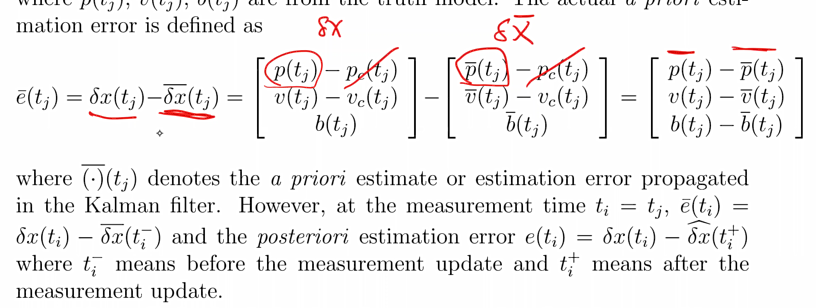

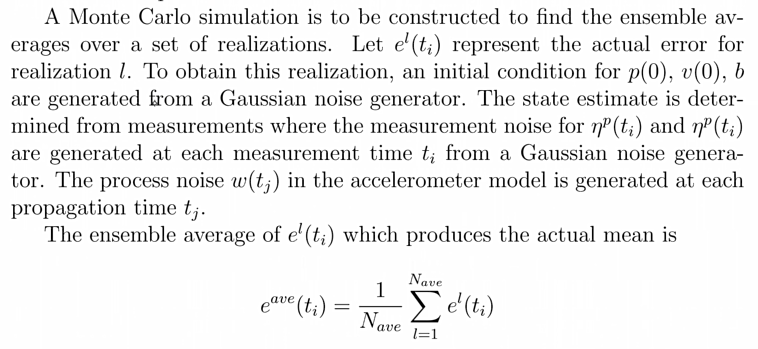

Add N_ave (number of realizations) in the report

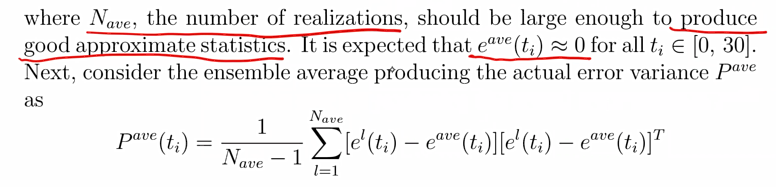

Should give 3 x 3 matrix with off-diagonal terms

Compare this P_ave with internal error P(t_i) computed for Kalman filter
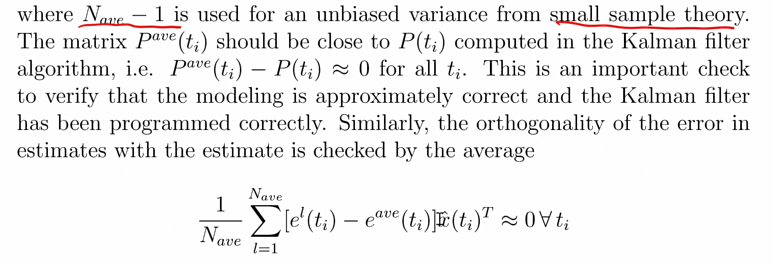

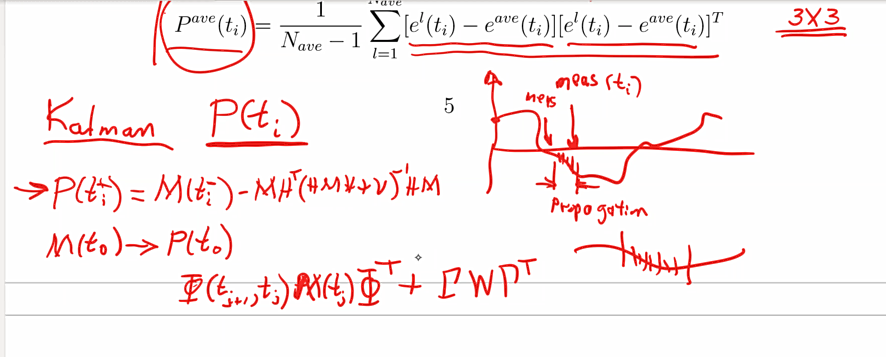

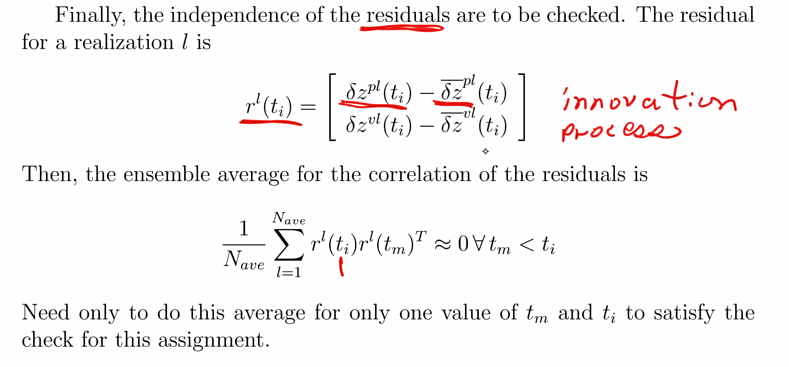

Show that the error and envelope are going to 0
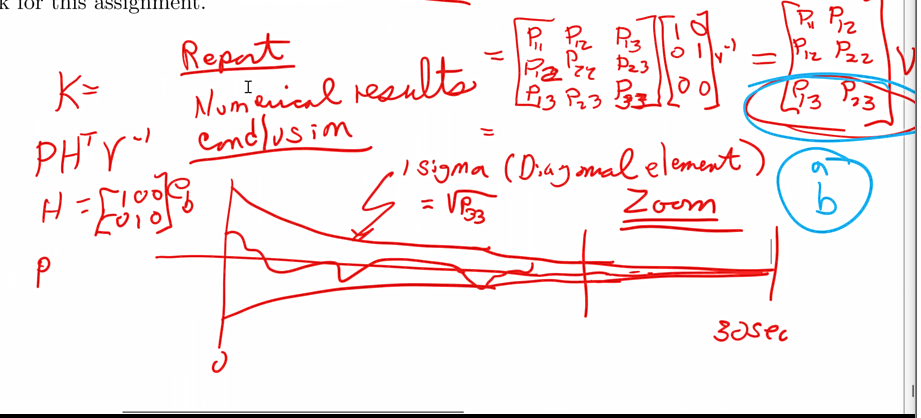